## Intro

We saw how to adapt dynamic programming to find approximate occurrences of a pattern in a text. Recall that:

* Rows of the dynamic programming matrix are labeled with bases from P and columns with bases from T
* Elements in the first row are set to 0
* Elements in the first column are set to 0, 1, 2, ..., as for edit distance
* Other elements are set in the same way as elements of a standard edit distance matrix
* The minimal value in the bottom row is the edit distance of the closest match between P and T


Adapt the <code>editDistance</code> function we saw in practical (copied below) to answer questions 1 and 2 below. Your function should take arguments p (pattern), t (text) and should return the edit distance of the match between P and T with the fewest edits.

In [1]:
def editDistance(x, y):
    # Create distance matrix
    D = []
    for i in range(len(x)+1):
        D.append([0]*(len(y)+1))
    # Initialize first row and column of matrix
    for i in range(len(x)+1):
        D[i][0] = i
    for i in range(len(y)+1):
        D[0][i] = 0
    # Fill in the rest of the matrix
    for i in range(1, len(x)+1):
        for j in range(1, len(y)+1):
            distHor = D[i][j-1] + 1
            distVer = D[i-1][j] + 1
            if x[i-1] == y[j-1]:
                distDiag = D[i-1][j-1]
            else:
                distDiag = D[i-1][j-1] + 1
            D[i][j] = min(distHor, distVer, distDiag)
    # Edit distance is the value in the bottom right corner of the matrix
    return min(D[-1][:])


Hint: In the "A new solution to approximate matching" video we saw that the best approximate match of P =GCGTATGC within T =TATTGGCTATACGGTT had 2 edits. You can use this and other small examples to double-check that your function is working.

In [2]:
p = 'GCGTATGC'
t = 'TATTGGCTATACGGTT'
editDistance(p, t)

2

### Questions

In [3]:
def readGenome(filename):
    genome = ''
    with open(filename, 'r') as f:
        for line in f:
            # ignore header line with genome information
            if not line[0] == '>':
                genome += line.rstrip()
    return genome

In [4]:
genome = readGenome('./data/chr1.GRCh38.excerpt.fasta')

> Question 1

What is the edit distance of the best match between pattern GCTGATCGATCGTACG and the excerpt of human chromosome 1?  (Don't consider reverse complements.)

In [5]:
p = 'GCTGATCGATCGTACG'
editDistance(p, genome)

3

> Question 2

What is the edit distance of the best match between pattern GATTTACCAGATTGAG and the excerpt of human chromosome 1?  (Don't consider reverse complements.)

In [6]:
p = 'GATTTACCAGATTGAG'
editDistance(p, genome)

2

## Overlap all pairs

In [7]:
def overlap(a, b, min_length=3):
    """ Return length of longest suffix of 'a' matching
        a prefix of 'b' that is at least 'min_length'
        characters long.  If no such overlap exists,
        return 0. """
    start = 0  # start all the way at the left
    while True:
        start = a.find(b[:min_length], start)  # look for b's prefix in a
        if start == -1:  # no more occurrences to right
            return 0
        # found occurrence; check for full suffix/prefix match
        if b.startswith(a[start:]):
            return len(a)-start
        start += 1  # move just past previous match

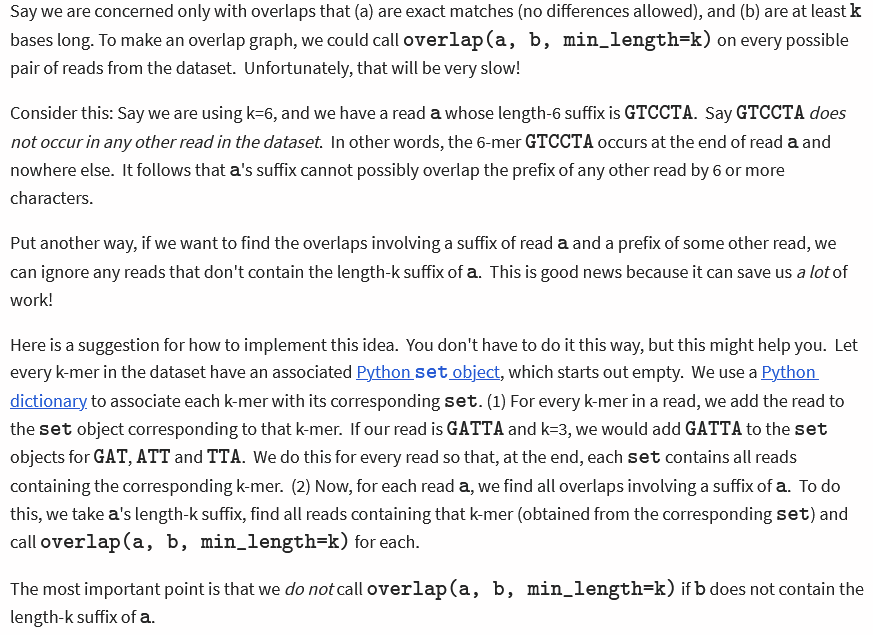

Next, find all pairs of reads with an exact suffix/prefix match of length at least 30. Don't overlap a read with itself; if a read has a suffix/prefix match to itself, ignore that match.  Ignore reverse complements.

* Hint 1: Your function should not take much more than 15 seconds to run on this 10,000-read dataset, and maybe much less than that.  (Our solution takes about 3 seconds.) If your function is much slower, there is a problem somewhere.

* Hint 2: Remember not to overlap a read with itself. If you do, your answers will be too high.

* Hint 3: You can test your implementation by making up small examples, then checking that (a) your implementation runs quickly, and (b) you get the same answer as if you had simply called overlap(a, b, min_length=k) on every pair of reads.  We also have provided a couple examples you can check against.

In [8]:
from itertools import permutations

def naive_overlap_map(reads, k):
    olaps = {}
    for a, b in permutations(reads, 2):
        olen = overlap(a, b, min_length=k)
        if olen > 0:
            olaps[(a, b)] = olen
    return olaps

In [9]:
def overlap_all_pairs(reads, k):
    olaps, res = {}, {}
    
    for read in reads:
        for i in range(len(read)-k+1):
            if read[i:k+i] not in olaps:
                olaps[read[i:k+i]] = set()
            olaps[read[i:k+i]].add(read)

    for read in reads:
        if read[-k:] in olaps:
            for item in olaps[read[-k:]]:
                if (read, item) not in res and read != item:
                    olen = overlap(read, item, min_length=k)
                    if olen > 0:
                        res[(read, item)] = olen

    return res

### Example 1

In [10]:
reads = ['ABCDEFG', 'EFGHIJ', 'HIJABC']

In [11]:
overlap_all_pairs(reads, 3)

{('ABCDEFG', 'EFGHIJ'): 3, ('EFGHIJ', 'HIJABC'): 3, ('HIJABC', 'ABCDEFG'): 3}

In [12]:
overlap_all_pairs(reads, 4)

{}

### Example 2

In [13]:
reads = ['CGTACG', 'TACGTA', 'GTACGT', 'ACGTAC', 'GTACGA', 'TACGAT']

In [14]:
naive_overlap_map(reads, 4)

{('CGTACG', 'TACGTA'): 4,
 ('CGTACG', 'GTACGT'): 5,
 ('CGTACG', 'GTACGA'): 5,
 ('CGTACG', 'TACGAT'): 4,
 ('TACGTA', 'CGTACG'): 4,
 ('TACGTA', 'ACGTAC'): 5,
 ('GTACGT', 'TACGTA'): 5,
 ('GTACGT', 'ACGTAC'): 4,
 ('ACGTAC', 'CGTACG'): 5,
 ('ACGTAC', 'GTACGT'): 4,
 ('ACGTAC', 'GTACGA'): 4,
 ('GTACGA', 'TACGAT'): 5}

In [15]:
overlap_all_pairs(reads, 4)

{('CGTACG', 'TACGTA'): 4,
 ('CGTACG', 'GTACGT'): 5,
 ('CGTACG', 'GTACGA'): 5,
 ('CGTACG', 'TACGAT'): 4,
 ('TACGTA', 'CGTACG'): 4,
 ('TACGTA', 'ACGTAC'): 5,
 ('GTACGT', 'TACGTA'): 5,
 ('GTACGT', 'ACGTAC'): 4,
 ('ACGTAC', 'GTACGA'): 4,
 ('ACGTAC', 'CGTACG'): 5,
 ('ACGTAC', 'GTACGT'): 4,
 ('GTACGA', 'TACGAT'): 5}

In [16]:
overlap_all_pairs(reads, 5)

{('CGTACG', 'GTACGA'): 5,
 ('CGTACG', 'GTACGT'): 5,
 ('TACGTA', 'ACGTAC'): 5,
 ('GTACGT', 'TACGTA'): 5,
 ('ACGTAC', 'CGTACG'): 5,
 ('GTACGA', 'TACGAT'): 5}

### Questions

In [17]:
def readFASTQ(filename):    
    f = open(filename)
    reads = []
    while True:
        h = f.readline()
        if len(h) == 0:
            break
        sequence = f.readline().rstrip()
        _ = f.readline()
        quality = f.readline().rstrip()
        reads.append(sequence)
        
    return reads

In [18]:
file = './data/ERR266411_1.for_asm.fastq'
reads = readFASTQ(file)

> Question 3

Picture the overlap graph corresponding to the overlaps just calculated.  How many edges are in the graph?  In other words, how many distinct pairs of reads overlap?

In [19]:
%%time
len(naive_overlap_map(reads, 30))

CPU times: total: 38.8 s
Wall time: 38.8 s


904746

In [20]:
%%time
len(overlap_all_pairs(reads, 30))

CPU times: total: 1.8 s
Wall time: 1.8 s


904746

> Question 4

Picture the overlap graph corresponding to the overlaps computed for the previous question. How many nodes in this graph have at least one outgoing edge?  (In other words, how many reads have a suffix involved in an overlap?)

In [21]:
nodes = set()
for edge in overlap_all_pairs(reads, 30):
    nodes.add(edge[0])
    nodes.add(edge[1])

print(len(nodes))

9750
